# Variational Autoencoder

In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
tf.set_random_seed(0)

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
def xavier_init(fan_in, fan_out, constant=1): 
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))

    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)

In [4]:
class VariationalAutoencoder(object):
    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus, 
                 learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        # Input
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])

        self._create_network()
        self._create_loss_optimizer()
        
        init = tf.global_variables_initializer()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
    
    def getZ(self, X):
        z_mean_, z_log_sigma_sq = self.sess.run((self.z_mean, self.z_log_sigma_sq), feed_dict={self.x: X})  
        
        return z_mean_, z_log_sigma_sq
    
    def _create_network(self):
        # Initialize weights and biases
        network_weights = self._initialize_weights(**self.network_architecture)

        # Use recognition network to determine mean and 
        # (log) variance of Gaussian distribution in latent
        # space
        self.z_mean, self.z_log_sigma_sq = \
            self._recognition_network(network_weights["weights_recog"], 
                                      network_weights["biases_recog"])
        
        print(self.z_mean.shape, self.z_log_sigma_sq.shape)
        # Draw one sample z from Gaussian distribution
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, 
                               dtype=tf.float32)
        # z = mu + sigma*epsilon
        self.z = tf.add(self.z_mean, tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps)

        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self.x_reconstr_mean = \
            self._generator_network(network_weights["weights_gener"],
                                    network_weights["biases_gener"])
            
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, n_hidden_recog_3,
                            n_hidden_gener_1,  n_hidden_gener_2, n_hidden_gener_3,
                            n_input, n_z):
        all_weights = dict()
        all_weights['weights_recog'] = {
            'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
            'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
            'h3': tf.Variable(xavier_init(n_hidden_recog_2, n_hidden_recog_3)),
            'out_mean': tf.Variable(xavier_init(n_hidden_recog_3, n_z), name = 'out_mean_W'),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_3, n_z), name = 'out_log_sigma_W')}
        all_weights['biases_recog'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
            'b3': tf.Variable(tf.zeros([n_hidden_recog_3], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32), name = 'out_mean_b'),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32), name = 'out_log_sigma_b')}
        all_weights['weights_gener'] = {
            'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
            'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
            'h3': tf.Variable(xavier_init(n_hidden_gener_2, n_hidden_gener_3)),
            'out_mean': tf.Variable(xavier_init(n_hidden_gener_3, n_input)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_3, n_input))}
        all_weights['biases_gener'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
            'b3': tf.Variable(tf.zeros([n_hidden_gener_3], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return all_weights
            
    def _recognition_network(self, weights, biases):
        # Generate probabilistic encoder 
        
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        layer_3 = self.transfer_fct(tf.add(tf.matmul(layer_2, weights['h3']), 
                                           biases['b3'])) 
        
        z_mean         = tf.add(tf.matmul(layer_3, weights['out_mean']),
                                biases['out_mean'])
        
        z_log_sigma_sq = tf.add(tf.matmul(layer_3, weights['out_log_sigma']), 
                                biases['out_log_sigma'])
        
        return (z_mean, z_log_sigma_sq)

    def _generator_network(self, weights, biases):
        # Generate probabilistic decoder
        
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        layer_3 = self.transfer_fct(tf.add(tf.matmul(layer_2, weights['h3']), 
                                           biases['b3'])) 
        
        x_reconstr_mean = tf.nn.sigmoid(tf.add(tf.matmul(layer_3, weights['out_mean']), 
                                        biases['out_mean']))
        return x_reconstr_mean
            
    def _create_loss_optimizer(self):
        # Two loss:
        #
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution 
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent
        #     is given.
        
        
        # Adding 1e-10 to avoid evaluation of log(0.0)
        reconstr_loss = \
            -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
                           + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean),
                           1)
        
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence 
        ##    between the distribution in latent space induced by the encoder on 
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the the latent space distribution given
        #     the prior.
        
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq 
                                           - tf.square(self.z_mean) 
                                           - tf.exp(self.z_log_sigma_sq), 1)
        
        # average over batch
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)   
        
        # Use ADAM optimizer
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
        
    def partial_fit(self, X):
        opt, cost = self.sess.run((self.optimizer, self.cost), 
                                  feed_dict={self.x: X})
        return cost
    
    def transform(self, X):
        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    
    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z: z_mu})
    
    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.x: X})

In [5]:
def train(network_architecture, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=5):
    vae = VariationalAutoencoder(network_architecture, 
                                 learning_rate=learning_rate, 
                                 batch_size=batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)

            # Fit training using batch data
            cost = vae.partial_fit(batch_xs)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), 
                  "cost=", "{:.9f}".format(avg_cost))
    return vae

## Reconstruction quality

In [6]:
network_architecture = \
    dict(n_hidden_recog_1=400, # 1st layer encoder neurons
         n_hidden_recog_2=200, # 2nd layer encoder neurons
         n_hidden_recog_3=100, # 3th layer encoder neurons
         n_hidden_gener_1=100, # 1st layer decoder neurons
         n_hidden_gener_2=200, # 2nd layer decoder neurons
         n_hidden_gener_3=400, # 3th layer decoder neurons
         n_input=784,          # MNIST data input (img shape: 28*28)
         n_z=10)               # dimensionality of latent space

vae = train(network_architecture, training_epochs=50)

(?, 10) (?, 10)
Epoch: 0001 cost= 191.798557906
Epoch: 0006 cost= 116.984586820
Epoch: 0011 cost= 110.947724235
Epoch: 0016 cost= 107.840588601
Epoch: 0021 cost= 105.858314625
Epoch: 0026 cost= 104.466968467
Epoch: 0031 cost= 103.424920543
Epoch: 0036 cost= 102.665690973
Epoch: 0041 cost= 102.042000067
Epoch: 0046 cost= 101.510464658


In [7]:
def getImagefromDataset(num):
    xs, ys = mnist.train.next_batch(1000)
    
    xs_l = []
    
    for i in range(1000):
        if np.argmax(ys[i]) == num:
            xs_l.append(xs[i])
    
    return xs_l

In [8]:
def getParams(num):
    imgsX    = getImagefromDataset(num)
    
    k       = len(imgsX)
    
    mu_t, sig_t = 0.0, 0.0
    
    for i in range(k):       
        mu, sig = vae.getZ([imgsX[i]])   
        mu_t   += mu
        sig_t  += np.sqrt(np.exp(sig))
    
    return mu_t/k, sig_t/k

In [9]:
def generateParameters():
    CLASSES = 10
    params  = []
    for i in range(CLASSES):
        mu, sigma = getParams(i)
        params.append([mu, sigma])
    return params

In [10]:
M = generateParameters()

In [11]:
def getImgFromVAE(inum):
    eps     = np.random.normal( -1, 1,(1, 10))
    z_      = M[inum][0] + M[inum][1] * eps
    z_mu    = np.array([z_[0]]*vae.batch_size)
    x_mean  = vae.generate(z_mu)
    img     = x_mean[0].reshape(28,28)
    
    return img

In [12]:
def getListOfNumbers(sNUM):
    res = []
    for i in range(len(sNUM)):
        img = getImgFromVAE(int(sNUM[i]))
        res.append(img)
    return res

In [22]:
#NUM        = input("Enter a number : ")
#input_imgs = getListOfNumbers(NUM)

#plt.imshow(input_imgs[0], cmap='gray')

# Captcha Generator

In [264]:
from random import randint
import random
import cv2

def rotate(img):
    sign=randint(-20,20)%2
    if sign==0:
        sign=-1   

    col = img.shape[0]    
    row = img.shape[1]    
    angle=(randint(1,100)%60)*sign
    img_center=tuple(np.array([row,col])/2)
    rot_mat = cv2.getRotationMatrix2D(img_center, angle,1)
    result = cv2.warpAffine(img, rot_mat, (col,row), flags=cv2.INTER_LINEAR)
    return result

def erosion(img,kernel):
    return cv2.erode(img,kernel,iterations = 1)

def dilation(img,kernel):
    return cv2.dilate(img,kernel,iterations = 2)
 
def opening(img,kernel):
    return cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
 
def closing(img,kernel):
    return cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
 
def gradient(img,kernel):
    return cv2.morphologyEx(img, cv2.MORPH_GRADIENT, kernel)
 
def morphology(img):
    dade   = randint(1,2)    
    kernel = np.ones((2,2),np.uint8)
    switcher = {
        1: erosion(img,kernel),
        2: dilation(img,kernel)
    #    3: opening(img,kernel),
    #    4: closing(img,kernel),
    #    5: gradient(img,kernel),
    }
    result = switcher.get(dade, lambda: "Invalid")
    return result

def scale(img):
    height=28
    width=28
    height = ( ( randint(1,2000) % 20 ) * -1 ) + height;
    width  = ( ( randint(1,2000) % 20 ) * -1 ) + width;
    result = cv2.resize(img,(height,width),interpolation=cv2.INTER_CUBIC)
    return result 

def traslation(img):
    rows,cols = img.shape
    pts1 = np.float32([[0,0],[0,rows],[cols,0],[rows,cols]])
    varWidth=rows/2
    varHeight=cols/2
    widthWarp=rows  + randint(-int(varWidth/1.0), int(varWidth/1.0))
    heightWarp=cols + randint(-int(varHeight/1.0),int(varHeight/1.0))
    
    pts2 = np.float32([[0,0],[0,rows],[cols,0],[widthWarp,heightWarp]])

    M = cv2.getPerspectiveTransform(pts1,pts2)

    dst = cv2.warpPerspective(img,M,(28,28))
    return dst


def addLines(image, chr_num):
    from random import randint
    numLines=randint(1, 4) 
    
    W = image.shape[0]
    for x in range(0,numLines):
        R     = randint(0,255)
        G     = randint(0,255)
        B     = randint(0,255)
        
        startX = randint(0, W*chr_num) % image.shape[1];
        endX   = randint(0, W*chr_num) % image.shape[1];
        startY = randint(0, W*chr_num) % image.shape[0];
        endY   = randint(0, W*chr_num) % image.shape[0];
        lines  = cv2.line(image,(startX,startY),(endX,endY), (R,G,B) ,randint(10, 15))
    return lines 

def sp_noise(image,prob):

    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output


def addNoise(image,chr_num):   
    numNoise = randint(120, 150) 
    W = image.shape[0]
    for x in range(0,numNoise):
        R     = randint(0,255)
        G     = randint(0,255)
        B     = randint(0,255)

        i = randint(0, W)  % image.shape[0];
        j = randint(0, W*chr_num)% image.shape[1];
        radius = randint(10,15)
        noise  = cv2.circle(image,(j,i),radius, (R,G,B), -1)      
    return noise

In [265]:
def captchaGenerator():
    NUM        = input("Enter a number : ")
    input_imgs = getListOfNumbers(NUM)

    normList = []
    
    
    for k in range(len(input_imgs)):
        norm = cv2.normalize(input_imgs[k], None,0, 255, cv2.NORM_MINMAX)
        normList.append(norm)


    captcha =[]
    
    
    for i in range(len(normList)):
        
        res_r = rotate(normList[i])
        res_t = traslation(res_r)
        res_t_res = cv2.resize(res_t, (0,0), fx=20, fy=20) 
        new   = morphology(res_t_res)
        new   = new.astype(np.uint8)
        
        #plt.imshow(new)
        #plt.show()
        new_RGB = cv2.cvtColor(new,cv2.COLOR_GRAY2RGB)
        color = np.zeros((*new.shape,3), np.uint8)
        
        R     = randint(0,255)
        G     = randint(0,255)
        B     = randint(0,255)
        color[:,:,:] = (R, G, B)
        ret, mask = cv2.threshold(new, 100, 255, cv2.THRESH_BINARY)
        mask_inv  = cv2.bitwise_not(mask)
        
        #bg  = np.zeros((*new.shape,3), np.uint8)
        
        img1_bg   = cv2.bitwise_and(new_RGB,new_RGB,mask = mask_inv)
        img2_fg   = cv2.bitwise_and(color,color,mask = mask)
        dst       = cv2.add(img1_bg,img2_fg)
        captcha.append(dst)
    
    chr_num = len(captcha)
    vis = np.concatenate((captcha), axis=1)
    
    lines_img      = np.zeros(vis.shape, dtype=np.uint8)
    lines_img      = addNoise(lines_img,chr_num)
    lines_img      = addLines(lines_img,chr_num)
    lines_img_blur = cv2.GaussianBlur(lines_img,(45,45),0)
    lines          = cv2.add(vis,lines_img_blur)
    #noise_img = addNoise(vis, chr_num)

    #noise_img_res = cv2.resize(noise_img, (0,0), fx=20, fy=20) 
    #lines         = addLines(noise_img,chr_num)
    plt.imshow(lines,cmap="gray")
    plt.show()    

Enter a number : 13546


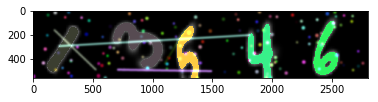

In [266]:
captchaGenerator()